FEAST v3.1 custom case

A field with wells and compressor station

# Defining an emission scenario
FEAST requires all potential emission sources to be declared as Components. Components are characterized by their emission production rate, emission size distribution, and the fraction of components expected to be emitting at the beginning of the simulation. In order to improve transparency, FEAST 3.1 does not have a "default" scenario. All emitters must be defined directly in order to run the simulation.

## Define fugitive components
For this example, we will define exactly one type of component: a fugitive emitter. Additional types of components can be created in the same way. Venting components (that is, components that are intended to produce emissions) can be created by setting the "base_reparable" variable to False. In real production sites vented and fugitive emissions will both be present.

## Define a production Site
A site is made of a collection of components. The components are stored in the variable comp_dict. The analyst may include many component types in the comp_dict.

Using the copy library is good practice if a component type is going to be reused in multiple sites to avoid shared parameters.

## Define a Time object
FEAST requires the simulation time settings to be declared in a time object.

## Define a GasField
All of the sites to be simulated must be collected into a dict and then passed to a GasField object. As of FEAST 3.1, a GasField object may also contain meteorological data.
Anaconda Field

# Define LDAR programs
LDAR programs are made of detection methods, repair methods, and the connections between them. The first step in creating LDAR programs is defining detection and repair methods.

## Define a repair method
A repair method takes one input parameter: the delay (days) between when an emission is detected and when it is repaired.

## Define detection methods
Detection methods accept a variety of variables that depend on the type of detection method to be simulated. In all cases, a detection method requires a set of conditions to be specified where the probability of detection (PoD) is known. Three examples are demonstrated below.

## Collect detection methods into LDARPrograms

# Run simulation

# Evaluating many simulations
FEAST is a stochastic model. Therefore, many iterations of the model should be considered to evaluate the variability between iterations. The cells below run 30 iterations of a simulation similar to that defined above, but without a continuous monitor method so that simulations can complete more quickly. The cell will take a few minutes to evaluate.

Note that many objects in FEAST must be re-created during each iteration in order to avoid results from the previous iteration persisting into the next simulation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import copy
import feast
import pickle
from multiprocessing import Pool

In [2]:
p = Pool(4)
list(p.map(os.remove, glob.glob("TutorialResults-MC-MyField/realization*.p")))

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [4]:
#from tutorial_helper import make_iteration
from myField_helper import make_iteration
from multiprocessing import Pool

In [5]:
nreal=100
with Pool(16) as p:
    p.map(make_iteration, [ind for ind in range(nreal)])

Currently evaluating iteration number 2Currently evaluating iteration number 4Currently evaluating iteration number 0Currently evaluating iteration number 12Currently evaluating iteration number 8Currently evaluating iteration number 10Currently evaluating iteration number 14Currently evaluating iteration number 20Currently evaluating iteration number 16Currently evaluating iteration number 6Currently evaluating iteration number 18Currently evaluating iteration number 22

Currently evaluating iteration number 28Currently evaluating iteration number 26
Currently evaluating iteration number 24




Currently evaluating iteration number 30







Currently evaluating iteration number 5
Currently evaluating iteration number 17
Currently evaluating iteration number 23
Currently evaluating iteration number 1
Currently evaluating iteration number 25
Currently evaluating iteration number 9
Currently evaluating iteration number 3
Currently evaluating iteration number 21
Currently evaluating iter

## Analyzing results
FEAST offers a few simple tools for analyzing multiple pickled results files. 
The results_analysis function calculates the net present value of the of finding leaks and repairing leaks. If the gas_price parameter is set greater than zero, it also accounts for the value of avoided emissions. The npv output of the function returns a dict containing one NxK array for each of these cash flows, where N is the number of iterations, and K is the number of technologies. The order of LDAR programs is specified by the *programs* output parameter.

In addition, *em_timeseries* contains an array of emission timeseries with dimension (N_programs + 1, N_timesteps, N_iterations). The first dimension is N_programs+1 because it includes an entry for the Null scenario as well as each LDAR program.

The abatement_cost_plotter function uses the results_analysis function to calculate and plot the mitigation cost of each LDAR program.

In [1]:
import feast
directory ='TutorialResults-MC-MyField' 
ra = feast.ResultsProcessing.results_analysis_functions.results_analysis
npv, em_timeseries, programs = ra(directory, gas_price=0, discount_rate=0)


em_timeseries:   (3, 365, 72)
em_ts_new:       (78840,)
type:    <class 'numpy.ndarray'>
iter_index:   78840
time_index:   78840
prog_index:   78840


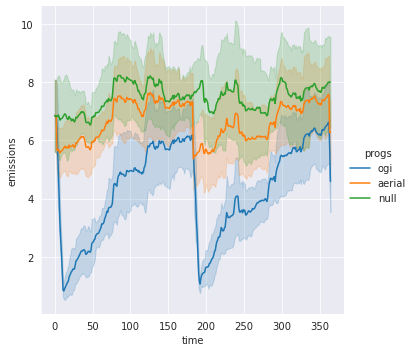

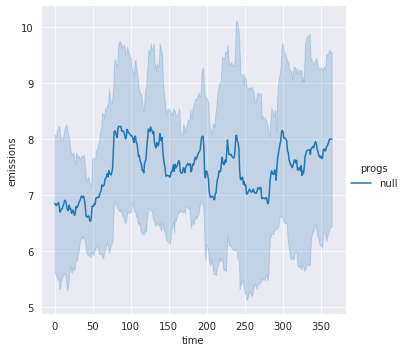

In [8]:
import numpy as np
import pandas as pd
import pprint
import seaborn

#pp = pprint.PrettyPrinter()
#pp.pprint(arr)
#arr1=arr.reshape(-1, 3)
#pp.pprint(arr1)
#em_ts_new = em_timeseries.reshape(1,-1)
em_ts_new=em_timeseries.flatten()
print('em_timeseries:  ',em_timeseries.shape)
print('em_ts_new:      ',em_ts_new.shape)
print('type:   ',type(em_ts_new))
iter_index = (list(np.arange(em_timeseries.shape[2]))*em_timeseries.shape[1])*em_timeseries.shape[0]
time_index =  list(np.repeat(np.arange(em_timeseries.shape[1]),em_timeseries.shape[2]))*em_timeseries.shape[0]
#prog_index =  list(np.repeat(np.arange(em_timeseries.shape[0]),(em_timeseries.shape[2]*em_timeseries.shape[1])))
prog_index =  np.repeat(np.array(['ogi','aerial','null']),(em_timeseries.shape[2]*em_timeseries.shape[1]))
print('iter_index:  ',len(iter_index))
#print('iter_index:  ',iter_index)
print('time_index:  ',len(time_index))
#print('time_index:  ',time_index)
print('prog_index:  ',len(prog_index))
#print('prog_index:  ',prog_index)

df = pd.DataFrame(em_ts_new, columns=['emissions'])
df.insert(0,'iters',iter_index)
df.insert(0,'progs',prog_index)
df.insert(0,'time',time_index)

clrs = seaborn.color_palette("husl", 5)
with seaborn.axes_style("darkgrid"):
    seaborn.relplot(x="time", y="emissions", kind="line", hue='progs', ci="sd", data=df);

with seaborn.axes_style("darkgrid"):
    seaborn.relplot(x="time", y="emissions", kind="line", hue='progs', ci="sd", data=df.query("progs == 'null'"));
#data=fmri.query("event == 'stim'")
#fmri = seaborn.load_dataset("fmri")
#seaborn.relplot(x="timepoint", y="signal", kind="line", data=fmri);

#print((fmri))

#df.index = np.repeat(np.arange(em_timeseries.shape[0]), em_timeseries.shape[1]) + 1
#df.index.name = 'DM'
#print(em_timeseries[:,:,0])

# Type, time, iteration


#seaborn.relplot(x="timepoint", y="signal",kind="line", data=em_timeseries);

0
1
2


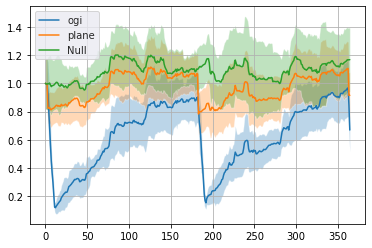

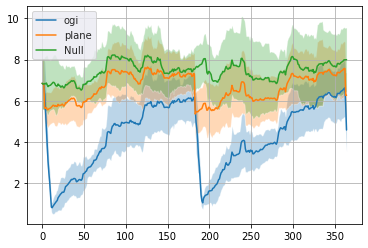

In [11]:
#calculating average and std per program
avg_emissions=np.zeros((em_timeseries.shape[0],em_timeseries.shape[1]))
std_emissions = copy.deepcopy(avg_emissions)

for progs in range(0, len(programs)):
    avg_emissions[progs] = np.mean(em_timeseries[progs],axis=1)
    std_emissions[progs] = np.std(em_timeseries[progs],axis=1)
    print(progs)

avgn_emissions = copy.deepcopy(avg_emissions)
stdn_emissions = copy.deepcopy(avg_emissions)
for progs in range(0, len(programs)):
    avgn_emissions[progs] = np.divide(avg_emissions[progs],avg_emissions[2,0])
    stdn_emissions[progs] = np.divide(std_emissions[progs],avg_emissions[2,0])

import seaborn as sns
fig, ax = plt.subplots()
clrs = sns.color_palette("husl", 5)
epochs = list(range(0,len(avg_emissions[0])))
with sns.axes_style("darkgrid"):
    for avg,std,progs in zip(avgn_emissions,stdn_emissions,programs):
        ax.plot(epochs,avg,label=progs)
        ax.fill_between(epochs,avg-std, avg+std,alpha=0.3)
    ax.legend()
    ax.grid()

import seaborn as sns
fig, ax = plt.subplots()
clrs = sns.color_palette("husl", 5)
epochs = list(range(0,len(avg_emissions[0])))
with sns.axes_style("darkgrid"):
    for avg,std,progs in zip(avg_emissions,std_emissions,programs):
        ax.plot(epochs,avg,label=progs)
        ax.fill_between(epochs,avg-std, avg+std,alpha=0.3)
    ax.legend()
    ax.grid()


In [9]:
    from os import listdir
    from os.path import isfile, join
    from pickle import load
    import numpy as np

    emissions = em_timeseries
    gwp=34
    discount_rate=0
    gas_price=0

    files = [f for f in listdir(directory) if isfile(join(directory, f)) and '.p' in f]
    with open(directory + '/' + files[0], 'rb') as f:
        sample = load(f)
    emissions = np.sum(emissions * sample.time.delta_t * 3600 * 24 / 1e6, axis=1)  # metric tonnes
    em_abate = np.zeros([emissions.shape[0] - 1, emissions.shape[1]])
    cost_abate = np.zeros([emissions.shape[0] - 1, emissions.shape[1]])
    for ind in range(em_abate.shape[0]):
        em_abate[ind, :] = emissions[-1, :] - emissions[ind, :]
        cost_abate[ind, :] = -npv['Total'][ind, :]
    abatement_cost = cost_abate / em_abate / gwp
    print('abatement cost shape:  ',abatement_cost.shape)
    

abatement cost shape:   (2, 72)
abatement cost:   [[ 36.66707771  36.66707771  36.66707771  36.66707771  36.66707771
   36.66707771  36.66707771  36.66707771  32.50252962  32.50252962
   32.50252962  32.50252962  32.50252962  32.50252962  32.50252962
   32.50252962  32.50252962  32.50252962  32.50252962  32.50252962
   27.34552806  30.85762261  30.85762261  30.85762261  30.85762261
   30.85762261  30.85762261  30.85762261  30.85762261  30.85762261
   30.85762261  27.34552806  30.85762261  30.85762261  30.85762261
   30.85762261  30.85762261  20.69638041  20.69638041  20.69638041
   20.69638041  20.69638041  27.34552806  20.69638041  20.69638041
   20.69638041  20.69638041  20.69638041  20.69638041  20.69638041
   20.69638041  25.07031081  25.07031081  27.34552806  25.07031081
   25.07031081  25.07031081  25.07031081  25.07031081  25.07031081
   25.07031081  25.07031081  25.07031081  25.07031081  27.34552806
   25.07031081  24.82904405  24.82904405  26.71460044  26.71460044
   27.345528

In [31]:
print(abatement_cost.shape)
cost_mean = abatement_cost.mean(axis=1)
cost_max  = abatement_cost.max(axis=1)
cost_min  = abatement_cost.min(axis=1)
cost_std  = abatement_cost.std(axis=1)
cost_median = np.median(abatement_cost,axis=1)

print('Cost:\n','  mean: ', cost_mean, '\n  median: ', cost_median,'\n   max:  ', cost_max, '\n   min:  ', cost_min,'\n   std:  ',cost_std)
print(programs)

(2, 72)
Cost:
   mean:  [28.27367066 58.87755349] 
  median:  [27.34552806 32.42393662] 
   max:   [ 36.66707771 307.52871016] 
   min:   [20.69638041 25.33673034] 
   std:   [ 4.98994369 51.46034137]
['ogi', 'plane', 'Null']


n:   72.0
bins:   [ 25.33673034  53.55592832  81.7751263  109.99432428 138.21352227
 166.43272025 194.65191823 222.87111621 251.09031419 279.30951218
 307.52871016]


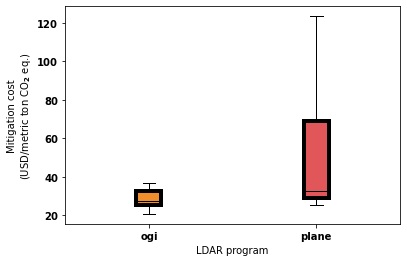

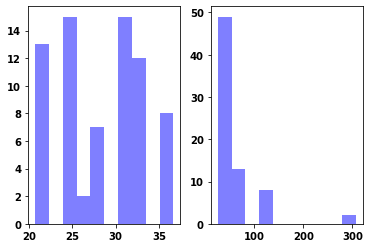

In [49]:
    import matplotlib.pyplot as plt
    from matplotlib import rc, rcParams
    # The color set defined here is the Tableau 10 color set.
    color_set = np.array([
        [78, 121, 167],
        [242, 142,  43],
        [225,  87,  89],
        [118, 183, 178],
        [89, 161,  79],
        [237, 201, 72],
        [176, 122, 161],
        [255, 157, 167],
        [156, 117,  95],
        [186, 176, 172]
    ]) / 255
    
    techs = programs
    medianprops = dict(color='k')
    boxprops = dict(linewidth=4)
    boxplot = plt.boxplot(np.transpose(abatement_cost), medianprops=medianprops,
                          boxprops=boxprops, patch_artist=True,showfliers=False)
    ind = 1
    for bx in boxplot['boxes']:
        bx.set(facecolor=color_set[ind])
        ind += 1
    ax = plt.gca()
    ax.set_xticklabels(techs[:len(techs) - 1])
    ax.set_ylabel('Mitigation cost\n(USD/metric ton CO$_2$ eq.)')
    ax.set_xlabel('LDAR program')
#    plot_fixer()

#x = [21,22,23,4,5,6,77,8,9,10,31,32,33,34,35,36,37,18,49,50,100]
x = abatement_cost[0]
num_bins = 10
fig1, ax = plt.subplots(1,2)
n, bins, patches = ax[0].hist(abatement_cost[0], num_bins, facecolor='blue', alpha=0.5)
n, bins, patches = ax[1].hist(abatement_cost[1], num_bins, facecolor='blue', alpha=0.5)
#fig1.show()
print('n:  ',n.sum(axis=0))
print('bins:  ',bins)



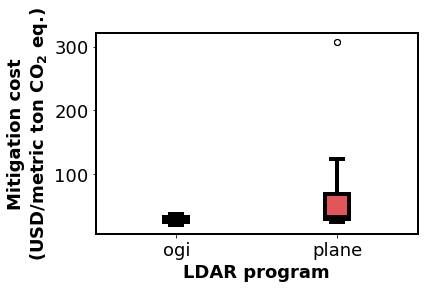

In [2]:
import feast
feast.ResultsProcessing.plotting_functions.abatement_cost_plotter(directory, 
                                                                  gwp=34, discount_rate=0, gas_price=0)

In [9]:
from datetime import datetime

now = datetime.now()

current_time = now.strftime("%d/%m/%Y  %H:%M:%S")
print("Current Time =", current_time)

Current Time = 10/11/2021  23:30:21


In [3]:
%run Example-RunScript.py

Iteration number: 0
The evaluation is 0% complete
The evaluation is 10% complete
The evaluation is 20% complete
The evaluation is 30% complete
The evaluation is 40% complete
The evaluation is 50% complete
The evaluation is 60% complete
The evaluation is 70% complete
The evaluation is 80% complete
The evaluation is 90% complete
Iteration number: 1
The evaluation is 0% complete
The evaluation is 10% complete
The evaluation is 20% complete
The evaluation is 30% complete
The evaluation is 40% complete
The evaluation is 50% complete
The evaluation is 60% complete
The evaluation is 70% complete
The evaluation is 80% complete
The evaluation is 90% complete
Iteration number: 2
The evaluation is 0% complete
The evaluation is 10% complete
The evaluation is 20% complete
The evaluation is 30% complete
The evaluation is 40% complete
The evaluation is 50% complete
The evaluation is 60% complete
The evaluation is 70% complete
The evaluation is 80% complete
The evaluation is 90% complete
Iteration num

ExampleRunScriptResults


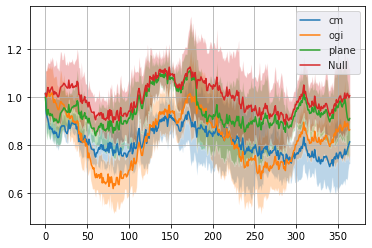

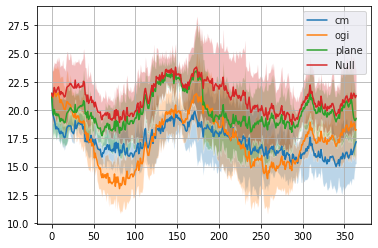

In [6]:
import FeastCustomPlots
ResultsDirectory = 'ExampleRunScriptResults'
FeastCustomPlots.TimeSeriesUncertainty(ResultsDirectory)

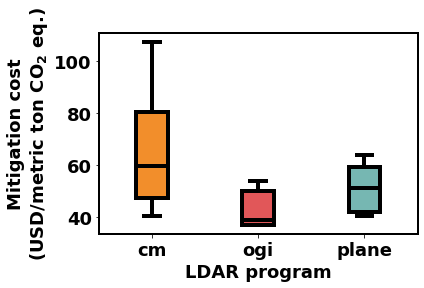

In [8]:
feast.ResultsProcessing.plotting_functions.abatement_cost_plotter(ResultsDirectory, 
                                                                  gwp=34, discount_rate=0, gas_price=0)

In [74]:
import numpy as np
import itertools


#array = geek.arrange(8) # The 'numpy' module has no attribute 'arrange'
#array = [np.arange(8)]
array=np.arange(8)

print(list(array))
print(np.sum(array))
new_array = [array]*3
print("Original array : \n", array)
print("New array : \n", (list(array)*3))

# Constructs 3D array
array = np.arange(9).reshape(1, 3, 3)
print("\nOriginal array reshaped to 3D : \n", array)
print('sum:  ',np.sum(array))
#array.reshape(2,-1)

planets = seaborn.load_dataset("planets")
print(planets)
print(np.zeros((2,2)))

[0, 1, 2, 3, 4, 5, 6, 7]
28
Original array : 
 [0 1 2 3 4 5 6 7]
New array : 
 [0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7]

Original array reshaped to 3D : 
 [[[0 1 2]
  [3 4 5]
  [6 7 8]]]
sum:   36
               method  number  orbital_period   mass  distance  year
0     Radial Velocity       1      269.300000   7.10     77.40  2006
1     Radial Velocity       1      874.774000   2.21     56.95  2008
2     Radial Velocity       1      763.000000   2.60     19.84  2011
3     Radial Velocity       1      326.030000  19.40    110.62  2007
4     Radial Velocity       1      516.220000  10.50    119.47  2009
...               ...     ...             ...    ...       ...   ...
1030          Transit       1        3.941507    NaN    172.00  2006
1031          Transit       1        2.615864    NaN    148.00  2007
1032          Transit       1        3.191524    NaN    174.00  2007
1033          Transit       1        4.125083    NaN    293.00  2008
1034        

In [86]:
#def abatement_cost_plotter(directory, gwp=34, discount_rate=0, gas_price=0):
    """
    Generates a box plot of the cost of abatement
    gwp defaults to 34, which is the value provided in the IPCC 5th assessment report including climate-carbon feedbacks
    (see Table 8.7, page 714 in Chapter 8 of Climate Change 2013: The Physical Science Basis.)

    :param directory: A directory containing one or more realizations of a scenario
    :param gwp: global warming potential of methane
    :param discount_rate: discount rate to use in NPV calculations
    :param gas_price: value of saved gas ($/g)
    :return:
    """
    import matplotlib.pyplot as plt
    from pickle import load
    from os import listdir
    from os.path import isfile, join
    import fnmatch
    import numpy as np
    from feast.ResultsProcessing import results_analysis_functions
    from matplotlib import rc, rcParams
    import pprint

    from feast.ResultsProcessing import results_analysis_functions

    gwp=34
    discount_rate=0
    gas_price = 0
    directory = 'TutorialResults-MC-MyField'
    npv, emissions, techs = results_analysis_functions.results_analysis(directory, discount_rate, gas_price)
    files = [f for f in listdir(directory) if isfile(join(directory, f)) and '.p' in f]
    
    with open(directory + '/' + files[0], 'rb') as f:
        sample = load(f)
    emissions_orig = emissions
    print('emissions from results_analysis:  ',emissions.shape)
    emissions = np.sum(emissions * sample.time.delta_t * 3600 * 24 / 1e6, axis=1)  # metric tonnes
    print
    em_abate = np.zeros([emissions.shape[0] - 1, emissions.shape[1]])
    cost_abate = np.zeros([emissions.shape[0] - 1, emissions.shape[1]])
    for ind in range(em_abate.shape[0]):
        em_abate[ind, :] = emissions[-1, :] - emissions[ind, :]
        cost_abate[ind, :] = -npv['Total'][ind, :]
    abatement_cost = cost_abate / em_abate / gwp
    medianprops = dict(color='k')
    boxprops = dict(linewidth=4)
    boxplot = plt.boxplot(np.transpose(abatement_cost), medianprops=medianprops,
                          boxprops=boxprops, patch_artist=True)
    ind = 1
    for bx in boxplot['boxes']:
        bx.set(facecolor=color_set[ind])
        ind += 1
    ax = plt.gca()
    ax.set_xticklabels(techs[:len(techs) - 1])
    ax.set_ylabel('Mitigation cost\n(USD/metric ton CO$_2$ eq.)')
    ax.set_xlabel('LDAR program')
    plot_fixer()

emissions from results_analysis:   (3, 365, 243)


NameError: name 'color_set' is not defined

In [104]:
print(sample.time.delta_t)
print('emissions_orig:  ',emissions_orig.shape)
print('emissions:  ',emissions.shape)
test=np.sum(emissions_orig,axis=0)
print(test.shape)

1
emissions_orig:   (3, 365, 243)
emissions:   (3, 243)
(365, 243)


In [108]:
test=np.arange(8)
print(test[-1])

7
